# Basic Tutorial

Since DFControl is aimed at improving the day to day quality of life of a material's scientist/anyone running DFT codes,
we will look at a simple demonstration of how by creating and submitting some
[Quantum-Espresso](https://www.quantum-espresso.org/) calculations on Si
starting from a cif file specifying the structure.

In [1]:
using DFControl
if !Servers.isalive(Server("localhost"))#hide
    @async DFC.Resource.run()#hide
end#hide

First we download the cif file, extract the `Structure` and assign the right pseudos to it.
In this case Si (F d -3 m :1) from http://www.crystallography.net/cod/9011998.cif

In [2]:
using Downloads
cif_file = Downloads.download("http://www.crystallography.net/cod/9011998.cif", "Si.cif")

structure = Structure(cif_file)
if false#hide
set_pseudos!(structure, "pbesol")
end#hide

***Warning : Site occupancies not found, assuming all occupancies = 1.
┌ Info: Structure extracted from Si.cif
│ 	cell parameters: 
│ 	 a = (5.4309401512146 Å, 0.0 Å, 0.0 Å)
│ 	 b = (0.0 Å, 5.4309401512146 Å, 0.0 Å)
│ 	 c = (0.0 Å, 0.0 Å, 5.4309401512146 Å)
│ 	nat = 8
└ 	elements = [:Si]


This assumes that the `"pbesol"` pseudopotential set was installed during the

Next we specify the executables with which to run the QE calculations.
We assume here that `mpirun` is installed and in the user's PATH, and that
QE is installed, and to be found in the `/opt/qe/bin`, change this according to your own
setup. The first argument to the constructor can be used as a label to later retrieve the executable after it was saved.

In [3]:
pw_exec = Exec("pw", "pw.x", "/opt/qe/bin/", :nk => 4)

Exec
  name: String "pw"
  exec: String "pw.x"
  dir: String "/opt/qe/bin/"
  flags: Array{DFControl.Calculations.ExecFlag}((1,))
  modules: Array{AbstractString}((0,))
  parallel: Bool true


Additional executable flags can be passed as varargs to the constructor of `Exec`,
e.g. `Exec("pw.x", "/opt/qe/bin/", :nk => 4, :ndiag => 2)`.

Then we create the first calculation for our job, we name it scf, which will be used to reference it later.
We also pass the executables to be used and additional flags to be set to the constructor.
Afterwards we set the kpoints to be used in the scf calculation.

In [4]:
scf_calculation = Calculation{QE}("scf", :calculation => "scf"; exec = pw_exec)
set_kpoints!(scf_calculation, (6, 6, 6, 1, 1, 1))

┌ Info: scf: -> verbosity:
└        set to: high


Calculation{QE}:
name  = scf
exec = pw.x
run   = true
data  = [:k_points]
flags:
	&control
			verbosity   => high
			calculation => scf


The code recognizes internally that this 6-Tuple corresponds to a
`K_POINTS (automatic)` block in QE. Alternatively (leading to an identical final result):

In [5]:
scf_calculation = Calculation{QE}("scf", :calculation => "scf"; exec = pw_exec,
                                  data = [InputData(:k_points, :automatic,
                                                    (6, 6, 6, 1, 1, 1))])  # We can now define our job:  job = Job("Si", structure, [scf_calculation], :ecutwfc => 20, :conv_thr => 1e-6; dir="job")  # Additional calculations would be be added to the list `[scf_calculation]`. # The flag => value pairs will set the specified flags to that value for all calculations in the job

Calculation{QE}:
name  = scf
exec = pw.x
run   = true
data  = [:k_points]
flags:
	&control
			calculation => scf


that allow recognize that flag, so it's ideal for things like cutoffs and smearing etc.

We are now ready to submit the job, which will run in the current working directory

In [6]:
if false #hide
    submit(job)
else #hide
    global job = Job(joinpath(splitdir(pathof(DFControl))[1], "..", "docs","src","assets", "job"))#hide
    pop!(job) #hide
end #hide

Calculation{QE}:
name  = bands
exec = pw.x
run   = true
data  = [:k_points]
flags:
	&control
			verbosity   => high
			calculation => bands
	&system
			ecutwfc => 20.0
	&electrons
			conv_thr => 1.0e-6


This will generate and save all calculation files, and the corresponding job script (`job.tt`),
and subsequently run the job.
First submission through `sbatch job.tt` will be tried, if that fails then the script will run
through `bash job.tt`.

After the job finishes the outputs can be parsed through

In [7]:
outputdata(job)

Dict{String, Dict{Symbol, Any}} with 2 entries:
  "bands" => Dict(:bands=>DFControl.Band[DFControl.Band:…
  "scf"   => Dict(:bands=>DFControl.Band[DFControl.Band:…

or for a specific calculation

In [8]:
outputdata(job)["scf"]

Dict{Symbol, Any} with 12 entries:
  :bands            => DFControl.Band[DFControl.Band:…
  :converged        => true
  :scf_iteration    => [1, 2, 3, 4]
  :timing           => DFControl.TimingData[TimingData("init_run", 20 milliseco…
  :highest_occupied => 6.0271
  :scf_steps        => 1
  :fermi            => 6.0271
  :total_energy     => [-365.093, -365.102, -365.105, -365.105]
  :n_scf            => 0
  :n_KS_states      => 16
  :accuracy         => [0.215165, 0.00953103, 0.00028119, 5.9e-7]
  :in_cell          => [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

This also demonstrates how a calculation can be referenced using its name
(remember that we named the calculation "scf" when creating it).

Now that the scf calculation finished succesfully, the next step is usually to
have a look at the bandstructure. For this we generate a bands calculation,
using the scf calculation as a template and a generated high symmetry k-point path
with 20 kpoints per segment.

In [9]:
bands_calc = Calculations.gencalc_bands(job["scf"], Structures.high_symmetry_kpath(job.structure, 20))

┌ Info: 
│ name = bands
│ infile = bands.in
└ outfile = bands.out


Calculation{QE}:
name  = bands
exec = pw.x
run   = false
data  = [:k_points]
flags:
	&control
			verbosity   => high
			calculation => bands
	&system
			ecutwfc => 20.0
	&electrons
			conv_thr => 1.0e-6


Observe the :calculation => "bands", and automatic setting of the :verbosity => "high" flags.
We now push! this calculation to the job queue

In [10]:
push!(job, bands_calc)

2-element Vector{Calculation}:
 Calculation{QE}:
name  = scf
exec = pw.x
run   = false
data  = [:k_points]
flags:
	&control
			calculation => scf
	&system
			ecutwfc => 20.0
	&electrons
			conv_thr => 1.0e-6

 Calculation{QE}:
name  = bands
exec = pw.x
run   = false
data  = [:k_points]
flags:
	&control
			verbosity   => high
			calculation => bands
	&system
			ecutwfc => 20.0
	&electrons
			conv_thr => 1.0e-6


However, since we know the scf succeeded there is no need to rerun it.
To un-schedule it we do

In [11]:
job["scf"].run = false

false

Printing the job will now highlight the scheduled calculations differently from the non-scheduled ones

In [12]:
job

+-------------------------------------------DFJOB-----------------------------------------+
| name:            Si                                                                     |
| dir:             /home/runner/work/DFControl.jl/DFControl.jl/src/../docs/src/assets/job |
| version:         0                                                                      |
| versions:        0                                                                      |
| last submission: 2022-02-01T12:38:11                                                    |
| state:           Unknown                                                                |
+-----------------------------------------------------------------------------------------+
(scheduled, not scheduled)
	scf <- ran last
	bands


Seeing that all is right we submit the job again

In [13]:
job.dir = "job"; #hide
if false #hide
    submit(job)
else #hide
    global job = Job(joinpath(splitdir(pathof(DFControl))[1], "..", "docs","src","assets", "job"));#hide
end #hide

+-------------------------------------------DFJOB-----------------------------------------+
| name:            Si                                                                     |
| dir:             /home/runner/work/DFControl.jl/DFControl.jl/src/../docs/src/assets/job |
| version:         0                                                                      |
| versions:        0                                                                      |
| last submission: 2022-02-01T12:38:11                                                    |
| state:           Unknown                                                                |
+-----------------------------------------------------------------------------------------+
(scheduled, not scheduled)
	scf <- ran last
	bands


We can access the bands through

In [14]:
bands = readbands(job);

or

In [15]:
bands = outputdata(job)["bands"][:bands];

They can be plotted too

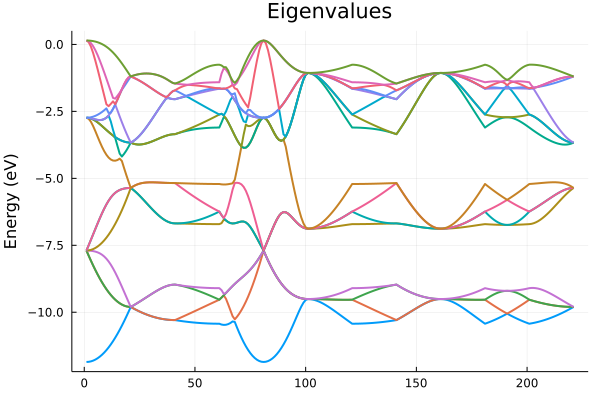

In [16]:
fermi = readfermi(job) # = outputdata(job)["scf"][:fermi]
using Plots
plot(bands; fermi = fermi)

Since more info (such as the structure) is available in the job,
plotting the job leads to a richer plot

[ Info: Plotting bands...


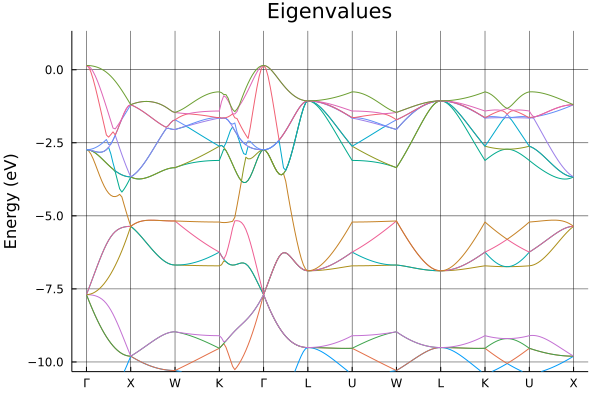

In [17]:
plot(job, -10, 1)

As can be seen in the Advanced Usage, additional information
generated by additional calculations will be picked up by DFControl
in order to create richer plots.